# Modèle LSTM de Classification de Données Textuelles

**Objectif :**

Créer une fonctionnalité de modération de contenu automatique pour notre plateforme sociale Page Turner.

Cette fonctionnalité vise à identifier et bloquer les commentaires toxiques parmi les commentaires saisis par les utilisateurs de manière à empêcher qu’ils soient postés sur la plateforme.

##  Etape 1 : Importation et initialisaton


**On importe les dépendances :**

- `os` : Utilisé pour travailler avec les chemins de fichiers et les structures de dossiers dans le système d'exploitation.

- `pandas` : Bibliothèque pour la manipulation et l'analyse de données. Utilisée pour lire, traiter et analyser les données structurées, en particulier les données tabulaires.

- `tensorflow` : Framework pour le deep learning et l'apprentissage automatique. Utilisé pour construire, entraîner et déployer des modèles d'apprentissage profond.

- `numpy` : Bibliothèque fondamentale pour les calculs scientifiques en Python. Elle fournit un support pour les opérations mathématiques sur des tableaux multidimensionnels et est souvent utilisée pour des tâches telles que les transformations de données et les calculs mathématiques.


In [ ]:
!pip install tensorflow pandas matplotlib scikit-learn

In [ ]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [ ]:
# Vérifie la disponibilité d'un GPU
print("GPUs disponibles : ", tf.config.list_physical_devices('GPU'))

GPUs disponibles :  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


##  Etape 2 : Chargement du Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Cours/L3/L2 - Projet/chat gpt/jigsaw-toxic-comment-classification-challenge/train.csv/train.csv'):
  for filename in filenames:
    print(os.path.join(dirname, filename))

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Cours/L3/L2 - Projet/chat gpt/jigsaw-toxic-comment-classification-challenge/train.csv/train.csv")


##  Etape 3 : Préparation des données


### A) Exploration des données

- `corpus` : Ensemble de données textuelles (en langue anglaise), spécifiquement des commentaires en ligne. Ces données proviennent de diverses sources publiques, offrant un large éventail de styles de communication, de tonalités et de contextes.

- `données` : Textes non structurés, composés de phrases, d'expressions et de mots utilisés dans les interactions en ligne. Ces données incluent une gamme de commentaires, allant de ceux considérés comme normaux et inoffensifs à ceux classifiés comme toxiques, sévèrement toxique, obscène, etc (6 labels au total).

In [ ]:
# observation du dataset
df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [ ]:
df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# observation du commentaire ligne 16
df.iloc[16]['comment_text']

"Bye! \n\nDon't look, come or think of comming back! Tosser."

In [ ]:
df[df.columns[2:]].iloc[16]

toxic            1
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
Name: 16, dtype: int64

In [ ]:
# observation des commentaires toxiques du dataset
df[df["toxic"]==1]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0
...,...,...,...,...,...,...,...,...
159494,fef4cf7ba0012866,"""\n\n our previous conversation \n\nyou fuckin...",1,0,1,0,1,1
159514,ff39a2895fc3b40e,YOU ARE A MISCHIEVIOUS PUBIC HAIR,1,0,0,0,1,0
159541,ffa33d3122b599d6,Your absurd edits \n\nYour absurd edits on gre...,1,0,1,0,1,0
159546,ffb47123b2d82762,"""\n\nHey listen don't you ever!!!! Delete my e...",1,0,0,0,1,0


### B) Nettoyage des données

Suppression des :
- `balises html`
- `liens web`
- `caractères spéciaux, ponctuation et chiffres`
- `double espaces`


In [ ]:
# Extrait de 100 commentaires toxiques avant nettoyage des données
df_t = df[df["toxic"]==1]
for i in range(100):
    cell_value = df_t.iat[i, df_t.columns.get_loc('comment_text')]
    print(cell_value)

COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
Hey... what is it..
@ | talk .
What is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?

Ask Sityush to clean up his behavior than issue me nonsensical warnings...
Bye! 

Don't look, come or think of comming back! Tosser.
You are gay or antisemmitian? 

Archangel WHite Tiger

Meow! Greetingshhh!

Uh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...

1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!

2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals!

3 - First and last warning, you fucking gay - I won't appreciate if any more nazi shwain would write in 

In [ ]:
import re
def clean_comment(comment):
    # Supprime les balises HTML
    comment = re.sub(r'<[^>]+>', '', comment)

    # Supprime les liens web
    comment = re.sub(r'http\S+|www\S+|https\S+', '', comment)

    # Supprime les caractères spéciaux, ponctuation et chiffres
    comment = re.sub(r'[^a-zA-Z\s\']', ' ', comment)

    # Supprime les doubles espaces
    comment = " ".join(comment.split())

    return comment

In [ ]:
df['comment_text'] =df['comment_text'].apply(clean_comment)

In [ ]:
# Extrait de 100 commentaires toxiques après nettoyage des données
df_t = df[df["toxic"]==1]
for i in range(100):
    cell_value = df_t.iat[i, df_t.columns.get_loc('comment_text')]
    print(f"--> {cell_value}")

--> COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
--> Hey what is it talk What is it an exclusive group of some WP TALIBANS who are good at destroying self appointed purist who GANG UP any one who asks them questions abt their ANTI SOCIAL and DESTRUCTIVE non contribution at WP Ask Sityush to clean up his behavior than issue me nonsensical warnings
--> Bye Don't look come or think of comming back Tosser
--> You are gay or antisemmitian Archangel WHite Tiger Meow Greetingshhh Uh there are two ways why you do erased my comment about WW that holocaust was brutally slaying of Jews and not gays Gypsys Slavs anyone If you are anti semitian than shave your head bald and go to the skinhead meetings If you doubt words of the Bible that homosexuality is a deadly sin make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals First and last warning you fucking gay I won't appreciate if any more nazi shwain would write in my page I don't wish to talk to you anymore Beware 

### C) Prétraitement des données
Préparation des données en vue de leur utilisation dans notre modèle.

In [ ]:
from tensorflow.keras.layers import TextVectorization

In [ ]:
X = df['comment_text'] # stock les commentaires
y = df[df.columns[2:]].values # stock les étiquettes

In [ ]:
X

0         Explanation Why the edits made under my userna...
1         D'aww He matches this background colour I'm se...
2         Hey man I'm really not trying to edit war It's...
3         More I can't make any real suggestions on impr...
4         You sir are my hero Any chance you remember wh...
                                ...                        
159566    And for the second time of asking when your vi...
159567    You should be ashamed of yourself That is a ho...
159568    Spitzer Umm theres no actual article for prost...
159569    And it looks like it was actually you who put ...
159570    And I really don't think you understand I came...
Name: comment_text, Length: 159571, dtype: object

In [ ]:
# Limite le vocabulaire aux 200 000 mots(tokens) les plus fréquents du dataset pour des raisons de performances et d'efficacité.
MAX_FEATURES = 200000

#### C.1) Initialisation de la Couche de Vectorisation de Texte


 Utile pour convertir les mots en indices et créer un vocabulaire.

In [ ]:
# Tokénisation : conversion de chaque commentaire en séquences de mots (tokens)
# Vectorisation : conversion de chaque token (mot) en valeur numérique

vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800, # la longueur du com ne peut pas excéder 1800 mots
                               output_mode='int') # convertit chaque mot en entier

#### C.2) Adaptation de la Couche de Vectorisation de Texte à nos données

 Création du vocabulaire : apprentissage du vocabulaire des commentaires.

In [ ]:
vectorizer.adapt(X.values)

In [ ]:
# Vérification du vocabulaire
vocab = vectorizer.get_vocabulary()
df = pd.DataFrame(vocab, columns=['Words'])
df.head(10)

,Words
0,
1,[UNK]
2,the
3,to
4,of
5,and
6,a
7,you
8,i
9,is


In [ ]:
# Test
vectorizer("hello world")

<tf.Tensor: shape=(1800,), dtype=int64, numpy=array([296, 253,   0, ...,   0,   0,   0])>

#### C.3) Application de la Couche de Vectorisation de Texte sur nos données


In [ ]:
# Sauvegarde l'état du vectoriseur pour une utilisation ultérieure
import pickle

pickle.dump({'config': vectorizer.get_config(),
             'weights': vectorizer.get_weights()}
            , open("tv_layer.pkl", "wb"))

In [ ]:
vectorized_text = vectorizer(X.values)

In [ ]:
vectorized_text

<tf.Tensor: shape=(159571, 1800), dtype=int64, numpy=
array([[   666,     78,      2, ...,      0,      0,      0],
       [150735,     54,   2507, ...,      0,      0,      0],
       [   403,    426,     70, ...,      0,      0,      0],
       ...,
       [ 30607,   6897,    394, ...,      0,      0,      0],
       [     5,     12,    559, ...,      0,      0,      0],
       [     5,      8,    134, ...,      0,      0,      0]])>

### D) Manipulation et Gestion des données pour l'entrainement

#### D.1) Création d'un pipeline de données avec TensorFlow

Un pipeline de données permet d'optimiser le traitement des données et d'assurer que celles-ci sont fournies au modèle de manière efficace et structurée.

- `Map` (Correspond à notre fonction 'vectorizer') :
Transforme le texte brut en vecteurs numériques compréhensible pour notre modèle.

- `Cache` (Mise en Cache) :
Les données transformées sont mises en cache, elles sont stockées temporairement, soit en mémoire, soit sur le disque. Permet de réduire le temps de chargement des données lors des itérations successives pendant l'entraînement du modèle.

- `Shuffle` (Mélange) :
En mélangeant les données, nous nous assurons que chaque lot de données est différent, ce qui réduit le risque de surapprentissage.

- `Batch` (Lot) :
Regroupe les données en lots de taille spécifiée.

- `Prefetch` (Préchargement) :
Le préchargement prépare les données pour les étapes suivantes pendant que le modèle est en train de s'entraîner. Permet de réduire les temps d'attente et optimise l'utilisation des ressources. Sans préchargement, le modèle pourrait devoir attendre que les données soient chargées et préparées, ce qui crée un goulot d'étranglement.

In [ ]:
#MCSHBAP - map, cache, shuffle, batch, prefetch
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # précharge 8 lots en avance

#### D.2) Création des partitions d'entraînement, de validation et de test

- `train` : L'entraînement du modèle se fait sur cet ensemble.

- `val` : L'ensemble de validation est utilisé pour évaluer le modèle pendant l'entraînement et pour ajuster les hyperparamètres.

- `test` : L'ensemble de test est utilisé pour évaluer la performance finale du modèle après l'entraînement.


In [ ]:
train = dataset.take(int(len(dataset)*.7)) # les 70% premiers éléments du dataset
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2)) # les 20% suivants
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1)) # les 10% restants

#### D.3) Création d'un itérateur

Un itérateur permet d'accéder aux données de manière séquentielle, lot par lot.

In [ ]:
train_generator = train.as_numpy_iterator()
train_generator.next()

(array([[  140,   194,    58, ...,     0,     0,     0],
        [   33,  1475,     2, ...,     0,     0,     0],
        [    8,    72,    41, ...,     0,     0,     0],
        ...,
        [ 1414,     7,   192, ...,     0,     0,     0],
        [28972, 16360,     8, ...,     0,     0,     0],
        [    8,   738,    10, ...,     0,     0,     0]]),
 array([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]]))

## Etape 4 : Création du Modèle

**Réseau de Neurones Séquentiel avec LSTM**

Ce modèle est un réseau de neurones séquentiel, caractérisé par une organisation linéaire de ses couches. Chaque couche est conçue pour recevoir les données traitées par la couche précédente, les transformer, puis passer le résultat à la couche suivante.

- `Couche d'Embedding` : Couche d'entrée qui transforme les indices de mots (tokens) en vecteurs denses. Elle est essentielle non seulement pour représenter l'identité unique de chaque mot, mais aussi pour capturer des aspects plus nuancés de leur signification et les relations sémantiques entre les mots.

- `Couche LSTM Bidirectionnelle` : Traite les informations dans les deux sens (avant et arrière) du texte. Utile pour comprendre le contexte complet de la phrase.

- `Couches Denses`: Couches composées de neurones entièrement connectés, utilisées pour extraire et apprendre des motifs complexes à partir des données.

- `Couche de Sortie`: La dernière couche du modèle est essentielle pour déterminer la ou les catégories à laquelle chaque commentaire appartient. Elle utilise la fonction d'activation 'sigmoid' qui est particulièrement adaptée pour les tâches de classification binaire ou multi-labels.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [ ]:
model = Sequential()
# Couche d'Embedding
model.add(Embedding(MAX_FEATURES+1, 32))
# Couche LSTM Bidirectionnelle
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Couches Denses
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Couche de Sortie
model.add(Dense(6, activation='sigmoid'))

In [ ]:
# configuration pour l'entraînement
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [ ]:
# Entraînement du modèle
history = model.fit(train, epochs=10, validation_data=val)

In [ ]:
# Sauvegarde du modèle entraîné
model.save('newModel.h5')

## Etape 5 : Evaluation du modèle

### A) Analyse Graphique

In [ ]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

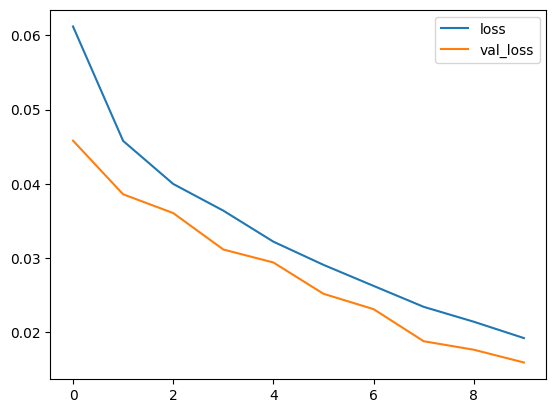

In [ ]:
# Analyse du modèle pour 10 époques
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

- `Convergence` : La perte d'entraînement et la perte de validation diminuent, ce qui indique que le modèle apprend et améliore ses prédictions au fil du temps.

- `Surapprentissage` : Il n'y a aucun signe évident de surapprentissage dans la plage d'époques fournie, car la perte de validation diminue en même temps que la perte d'entraînement. Le surapprentissage serait indiqué par une perte de validation qui commence à augmenter ou stagne tandis que la perte d'entraînement continue de diminuer.

### B) Analyse des métriques de performance

Evaluation des métriques de performance sur l'ensemble de test pour voir comment le modèle performe sur des données non vues.

- `La précision` : est une mesure de la qualité des prédictions positives du modèle. La précision répond à la question : "Parmi tous les cas que le modèle a prédits comme étant positifs, combien étaient réellement positifs ?"


- `Le rappel` : est une métrique utilisée pour évaluer la capacité d'un modèle de classification à identifier correctement les cas positifs. Le rappel répond à la question : "Parmi tous les cas réellement positifs, combien le modèle a-t-il réussi à identifier ?"


- `L'exactitude (accuracy)` : est une mesure de la performance globale du modèle.

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [ ]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
    # Unpack the batch
    X_true, y_true = batch
    # Make a prediction
    yhat = model.predict(X_true)

    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()

    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

In [ ]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Result for 10 Epoch :  
Precision: 0.9132593274116516,
Recall:0.9254217147827148,
Accuracy:0.49949848651885986

### C) Test : utilisation du modèle pour faire des prédictions

Appliquer à notre modèle entraîné de nouvelles données pour obtenir des prédictions.

In [ ]:
input_text = vectorizer('I hate Harry, he deserves to die !')

In [ ]:
model.predict

In [ ]:
res = model.predict(input_text)

In [ ]:
(res > 0.5).astype(int)

In [ ]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [ ]:
(model.predict(batch_X) > 0.5).astype(int)

In [ ]:
res.shape